In [2]:
import pyspark
spark = pyspark.sql.SparkSession.builder.appName("clipper-pyspark").getOrCreate()
sc = spark.sparkContext

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/05 16:20:36 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
np.random.seed(60)

In [18]:
#Read the data into spark datafrome
from pyspark.sql.functions import col, lower
df = spark.read.format('csv')\
          .option('header','true')\
          .option('inferSchema', 'true')\
          .option('timestamp', 'true')\
          .load('hdfs://127.0.0.1:9000/user/ADB_Project/train.csv')

data = df.select(lower(col('Category')),lower(col('Descript')))\
        .withColumnRenamed('lower(Category)','Category')\
        .withColumnRenamed('lower(Descript)', 'Description')
data.cache()
print('Dataframe Structure')
print('----------------------------------')
print(data.printSchema())
print(' ')
print('Dataframe preview')
print(data.show(5))
print(' ')
print('----------------------------------')
print('Total number of rows', df.count())

23/12/05 16:26:50 WARN CacheManager: Asked to cache already cached data.        


Dataframe Structure
----------------------------------
root
 |-- Category: string (nullable = true)
 |-- Description: string (nullable = true)

None
 
Dataframe preview
+--------------+--------------------+
|      Category|         Description|
+--------------+--------------------+
|      warrants|      warrant arrest|
|other offenses|traffic violation...|
|other offenses|traffic violation...|
| larceny/theft|grand theft from ...|
| larceny/theft|grand theft from ...|
+--------------+--------------------+
only showing top 5 rows

None
 
----------------------------------
Total number of rows 878049


In [23]:
import plotly.graph_objects as go
import plotly.express as px
def plot_column_distribution(df, column):
    """Plot the distribution of the column from dataframe"""
    
    column_val_df = df[column].value_counts().to_frame().reset_index()
    column_val_df.columns = [column, 'count']
    
    fig = px.bar(data_frame=column_val_df, x=column, y='count')
    fig.update_layout(
        autosize=True,
        height=600,
        hovermode='closest',
        showlegend=True,
        margin=dict(l=10, r=10, t=30, b=0)
    )
    
    fig.show()
    return None

In [8]:
def top_n_list(df,var, N):
    '''
    This function determine the top N numbers of the list
    '''
    print("Total number of unique value of"+' '+var+''+':'+' '+str(df.select(var).distinct().count()))
    print(' ')
    print('Top'+' '+str(N)+' '+'Crime'+' '+var)
    df.groupBy(var).count().withColumnRenamed('count','totalValue')\
    .orderBy(col('totalValue').desc()).show(N)
    
    
top_n_list(data, 'Category',39)
print(' ')
print(' ')
top_n_list(data,'Description',40)
result_df = df.groupBy('Category').count() \
    .withColumnRenamed('count', 'totalValue') \
    .orderBy(col('totalValue').desc())

Total number of unique value of Category: 39
 
Top 39 Crime Category


+--------------------+----------+
|            Category|totalValue|
+--------------------+----------+
|       larceny/theft|    174900|
|      other offenses|    126182|
|        non-criminal|     92304|
|             assault|     76876|
|       drug/narcotic|     53971|
|       vehicle theft|     53781|
|           vandalism|     44725|
|            warrants|     42214|
|            burglary|     36755|
|      suspicious occ|     31414|
|      missing person|     25989|
|             robbery|     23000|
|               fraud|     16679|
|forgery/counterfe...|     10609|
|     secondary codes|      9985|
|         weapon laws|      8555|
|        prostitution|      7484|
|            trespass|      7326|
|     stolen property|      4540|
|sex offenses forc...|      4388|
|  disorderly conduct|      4320|
|         drunkenness|      4280|
|   recovered vehicle|      3138|
|          kidnapping|      2341|
|driving under the...|      2268|
|             runaway|      1946|
|         liqu

Total number of unique value of Description: 879
 
Top 40 Crime Description


+--------------------+----------+
|         Description|totalValue|
+--------------------+----------+
|grand theft from ...|     60022|
|       lost property|     31729|
|             battery|     27441|
|   stolen automobile|     26897|
|drivers license, ...|     26839|
|      warrant arrest|     23754|
|suspicious occurr...|     21891|
|aided case, menta...|     21497|
|petty theft from ...|     19771|
|malicious mischie...|     17789|
|   traffic violation|     16471|
|petty theft of pr...|     16196|
|malicious mischie...|     15957|
|threats against life|     14716|
|      found property|     12146|
|enroute to outsid...|     11470|
|grand theft of pr...|     11010|
|possession of nar...|     10050|
|petty theft from ...|     10029|
|petty theft shopl...|      9571|
|grand theft from ...|      9512|
|        found person|      9317|
|    resisting arrest|      8983|
|credit card, thef...|      8877|
|    missing juvenile|      8620|
|        stolen truck|      8591|
|miscellaneous

In [9]:
data.select('Category').distinct().count()

39

In [10]:
training, test = data.randomSplit([0.7,0.3], seed=60)
#trainingSet.cache()
print("Training Dataset Count:", training.count())
print("Test Dataset Count:", test.count())

Training Dataset Count: 614457
Test Dataset Count: 263592


In [11]:
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover, CountVectorizer, OneHotEncoder, StringIndexer, VectorAssembler, HashingTF, IDF, Word2Vec
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, NaiveBayes 

#----------------Define tokenizer with regextokenizer()------------------
regex_tokenizer = RegexTokenizer(pattern='\\W')\
                  .setInputCol("Description")\
                  .setOutputCol("tokens")

#----------------Define stopwords with stopwordsremover()---------------------
extra_stopwords = ['http','amp','rt','t','c','the']
stopwords_remover = StopWordsRemover()\
                    .setInputCol('tokens')\
                    .setOutputCol('filtered_words')\
                    .setStopWords(extra_stopwords)
                    

#----------Define bags of words using countVectorizer()---------------------------
count_vectors = CountVectorizer(vocabSize=10000, minDF=5)\
               .setInputCol("filtered_words")\
               .setOutputCol("features")


#-----------Using TF-IDF to vectorise features instead of countVectoriser-----------------
hashingTf = HashingTF(numFeatures=10000)\
            .setInputCol("filtered_words")\
            .setOutputCol("raw_features")
            
#Use minDocFreq to remove sparse terms
idf = IDF(minDocFreq=5)\
        .setInputCol("raw_features")\
        .setOutputCol("features")

#---------------Define bag of words using Word2Vec---------------------------
word2Vec = Word2Vec(vectorSize=1000, minCount=0)\
           .setInputCol("filtered_words")\
           .setOutputCol("features")

#-----------Encode the Category variable into label using StringIndexer-----------
label_string_idx = StringIndexer()\
                  .setInputCol("Category")\
                  .setOutputCol("label")

#-----------Define classifier structure for logistic Regression--------------
lr = LogisticRegression(maxIter=20, regParam=0.3, elasticNetParam=0)

#---------Define classifier structure for Naive Bayes----------
nb = NaiveBayes(smoothing=1)

def metrics_ev(labels, metrics):
    '''
    List of all performance metrics
    '''
    # Confusion matrix
    print("---------Confusion matrix-----------------")
    print(metrics.confusionMatrix)
    print(' ')    
    # Overall statistics
    print('----------Overall statistics-----------')
    print("Precision = %s" %  metrics.precision())
    print("Recall = %s" %  metrics.recall())
    print("F1 Score = %s" % metrics.fMeasure())
    print(' ')
    # Statistics by class
    print('----------Statistics by class----------')
    for label in sorted(labels):
       print("Class %s precision = %s" % (label, metrics.precision(label)))
       print("Class %s recall = %s" % (label, metrics.recall(label)))
       print("Class %s F1 Measure = %s" % (label, metrics.fMeasure(label, beta=1.0)))
    print(' ')
    # Weighted stats
    print('----------Weighted stats----------------')
    print("Weighted recall = %s" % metrics.weightedRecall)
    print("Weighted precision = %s" % metrics.weightedPrecision)
    print("Weighted F(1) Score = %s" % metrics.weightedFMeasure())
    print("Weighted F(0.5) Score = %s" % metrics.weightedFMeasure(beta=0.5))
    print("Weighted false positive rate = %s" % metrics.weightedFalsePositiveRate)
    

In [12]:
pipeline_cv_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, lr])
model_cv_lr = pipeline_cv_lr.fit(training)
predictions_cv_lr = model_cv_lr.transform(test)


23/12/05 16:22:38 WARN InstanceBuilder: Failed to load implementation from:dev.ludovic.netlib.blas.JNIBLAS


In [13]:
print('-----------------------------Check Top 5 predictions----------------------------------')
print(' ')
predictions_cv_lr.select('Description','Category',"probability","label","prediction")\
                 .orderBy("probability", ascending=False)\
                 .show(n=5, truncate=30)

-----------------------------Check Top 5 predictions----------------------------------
 


+------------------------------+-------------+------------------------------+-----+----------+
|                   Description|     Category|                   probability|label|prediction|
+------------------------------+-------------+------------------------------+-----+----------+
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382391,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382391,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382391,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382391,0.02156...|  0.0|       0.0|
|theft, bicycle, <$50, no se...|larceny/theft|[0.8717529184382391,0.02156...|  0.0|       0.0|
+------------------------------+-------------+------------------------------+-----+----------+
only showing top 5 rows



In [14]:
from pyspark.ml.evaluation import MulticlassClassificationEvaluator 
evaluator_cv_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_lr)
print(' ')
print('------------------------------Accuracy----------------------------------')
print(' ')
print('accuracy:{}:'.format(evaluator_cv_lr))

 
------------------------------Accuracy----------------------------------
 
accuracy:0.9723579882349168:


In [15]:
### Secondary model using NaiveBayes
pipeline_cv_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,count_vectors,label_string_idx, nb])
model_cv_nb = pipeline_cv_nb.fit(training)
predictions_cv_nb = model_cv_nb.transform(test)

In [16]:
evaluator_cv_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_cv_nb)
print(' ')
print('--------------------------Accuracy-----------------------------')
print(' ')
print('                      accuracy:{}:'.format(evaluator_cv_nb))

 
--------------------------Accuracy-----------------------------
 
                      accuracy:0.9935325400900984:


In [ ]:
from pyspark.ml import PipelineModel
model_cv_nb.save("/Users/csuftitan/Documents/Spark/model_cv_nb123")

In [ ]:
pipeline_idf_lr = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, lr])
model_idf_lr = pipeline_idf_lr.fit(training)
predictions_idf_lr = model_idf_lr.transform(test)

In [ ]:
evaluator_idf_lr = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_lr)
print(' ')
print('-------------------------------Accuracy---------------------------------')
print(' ')
print('                        accuracy:{}:'.format(evaluator_idf_lr))

In [ ]:
pipeline_idf_nb = Pipeline().setStages([regex_tokenizer,stopwords_remover,hashingTf, idf, label_string_idx, nb])
model_idf_nb = pipeline_idf_nb.fit(training)
predictions_idf_nb = model_idf_nb.transform(test)

In [ ]:
evaluator_idf_nb = MulticlassClassificationEvaluator().setPredictionCol("prediction").evaluate(predictions_idf_nb)
print(' ')
print('-----------------------------Accuracy-----------------------------')
print(' ')
print('                          accuracy:{}:'.format(evaluator_idf_nb))

<Figure size 640x480 with 0 Axes>

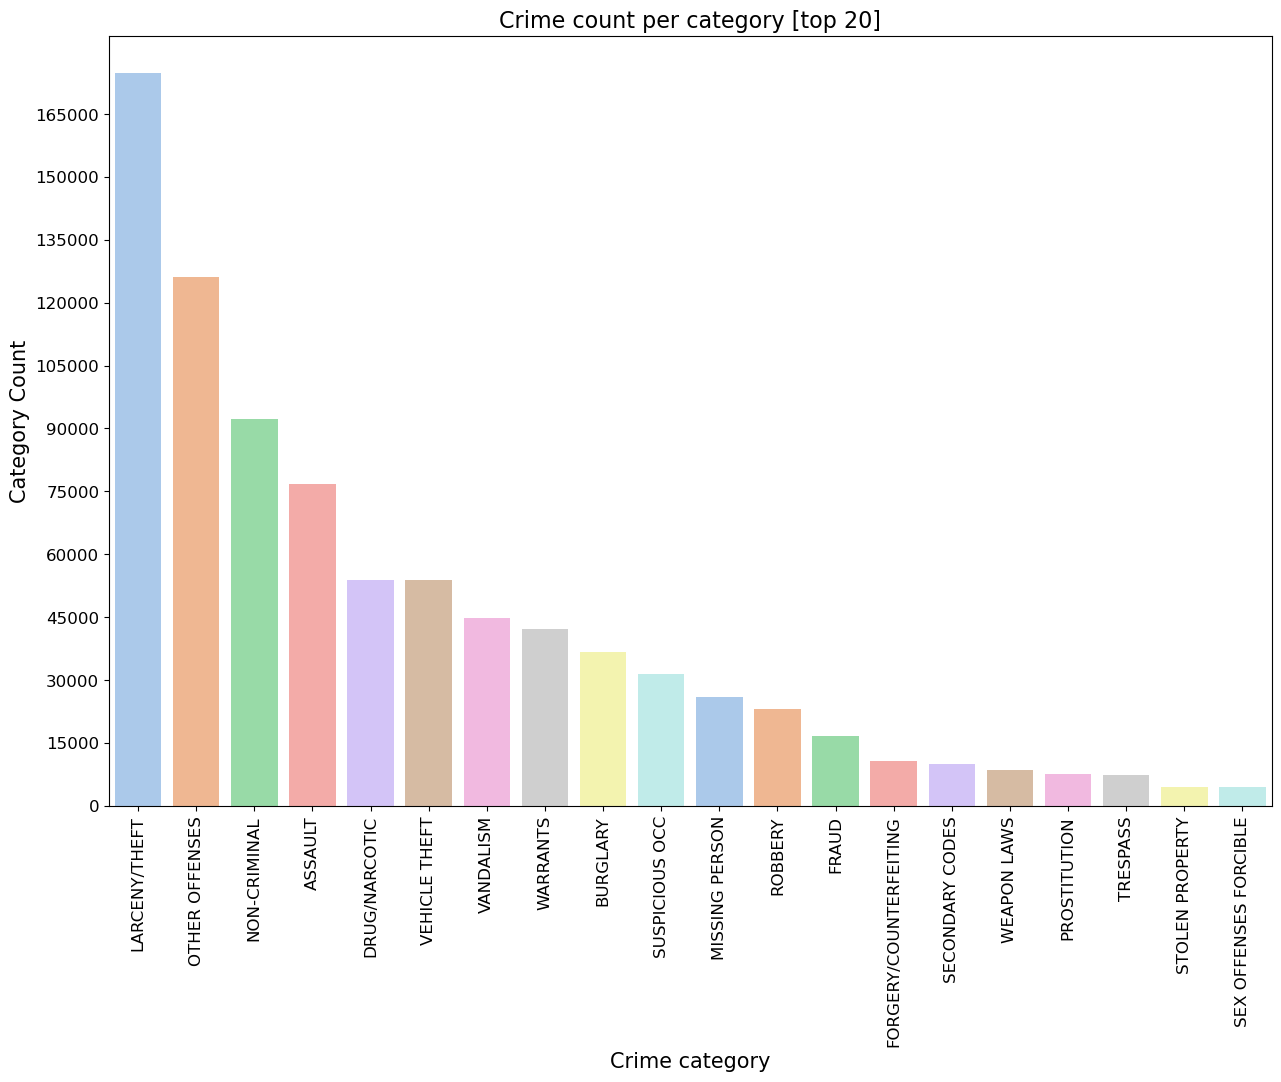

In [56]:
from pyspark.sql.functions import count, desc
category_counts = df.groupBy("Category").agg(count("Category").alias("crime_count_per_category")) \
    .orderBy(desc("crime_count_per_category"))

# Collect the results to the driver
# Collect the results to the driver and convert to a list of tuples
category_counts_list = category_counts.limit(20).collect()
data_for_plot = [(row["Category"], row["crime_count_per_category"]) for row in category_counts_list]

# Extract data for plotting
x, y = zip(*data_for_plot)

# Plotting the top 20 crime categories ordered ascendingly by count of each category
plt.clf()
plt.subplots(figsize=(15, 10))
sns.barplot(x=list(x), y=list(y), palette='pastel')

plt.xlabel("Crime category", fontsize=15)
plt.ylabel("Category Count", fontsize=15)
plt.title("Crime count per category [top 20]", fontsize=16)
plt.xticks(size=12, rotation=90)
plt.yticks(ticks=list(range(0, 177000, 15000)), size=12)
plt.show()


<Figure size 640x480 with 0 Axes>

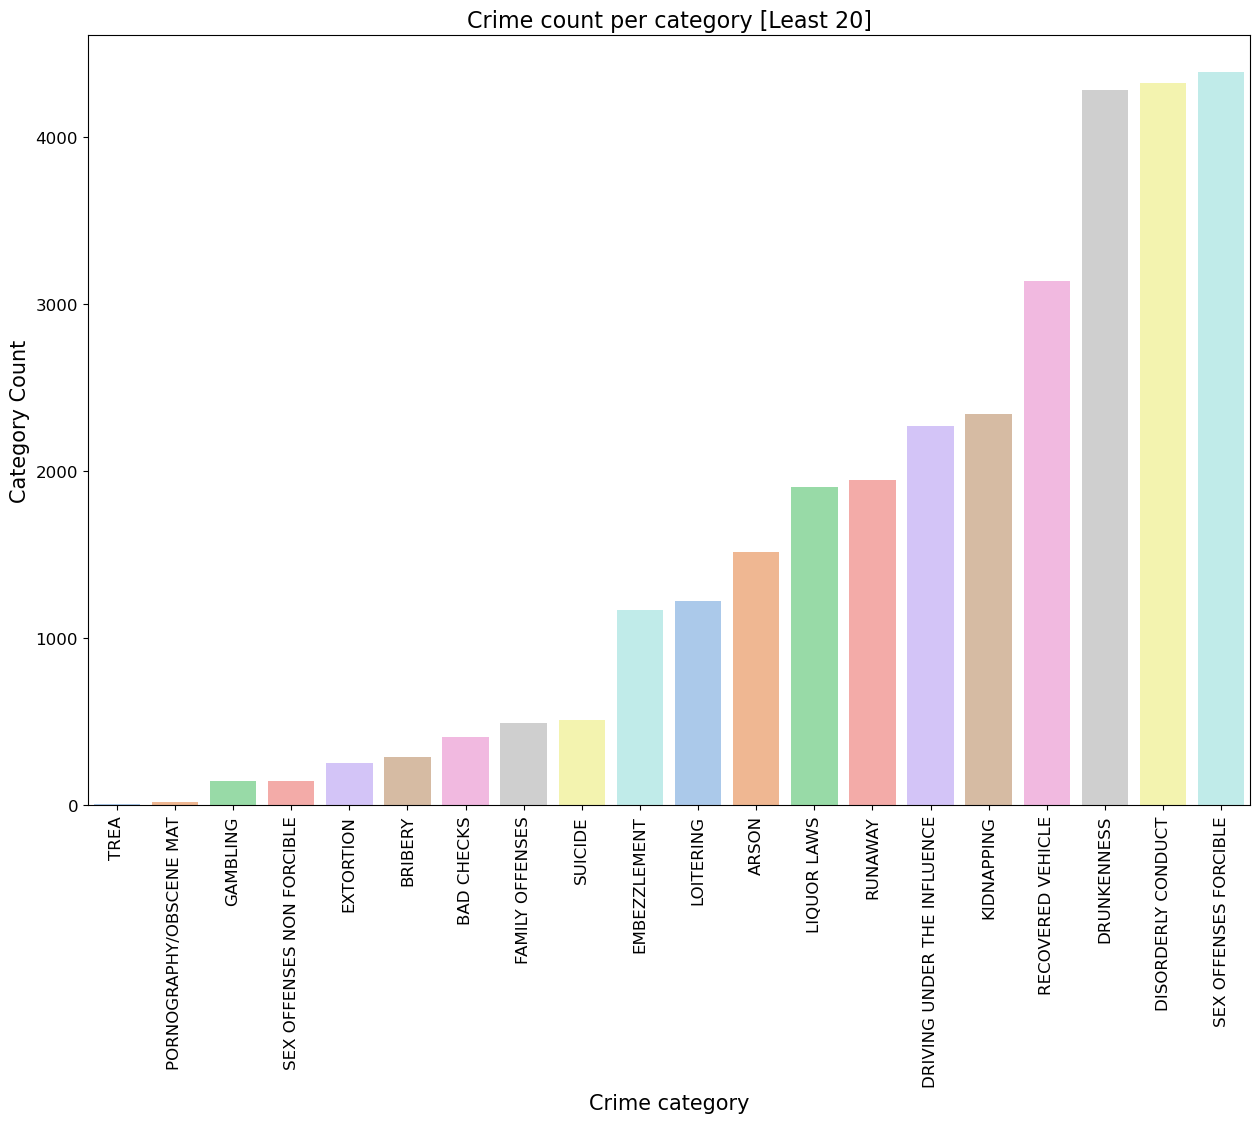

In [65]:
from pyspark.sql.functions import count, asc
category_counts = df.groupBy("Category").agg(count("Category").alias("crime_count_per_category")) \
    .orderBy(asc("crime_count_per_category"))

# Collect the results to the driver
# Collect the results to the driver and convert to a list of tuples
category_counts_list = category_counts.limit(20).collect()
data_for_plot = [(row["Category"], row["crime_count_per_category"]) for row in category_counts_list]

# Extract data for plotting
x, y = zip(*data_for_plot)

# Plotting the top 20 crime categories ordered ascendingly by count of each category
plt.clf()
plt.subplots(figsize=(15, 10))
sns.barplot(x=list(x), y=list(y), palette='pastel')

plt.xlabel("Crime category", fontsize=15)
plt.ylabel("Category Count", fontsize=15)
plt.title("Crime count per category [Least 20]", fontsize=16)
plt.xticks(size=12, rotation=90)
plt.yticks(size=12)
plt.show()

<Figure size 640x480 with 0 Axes>

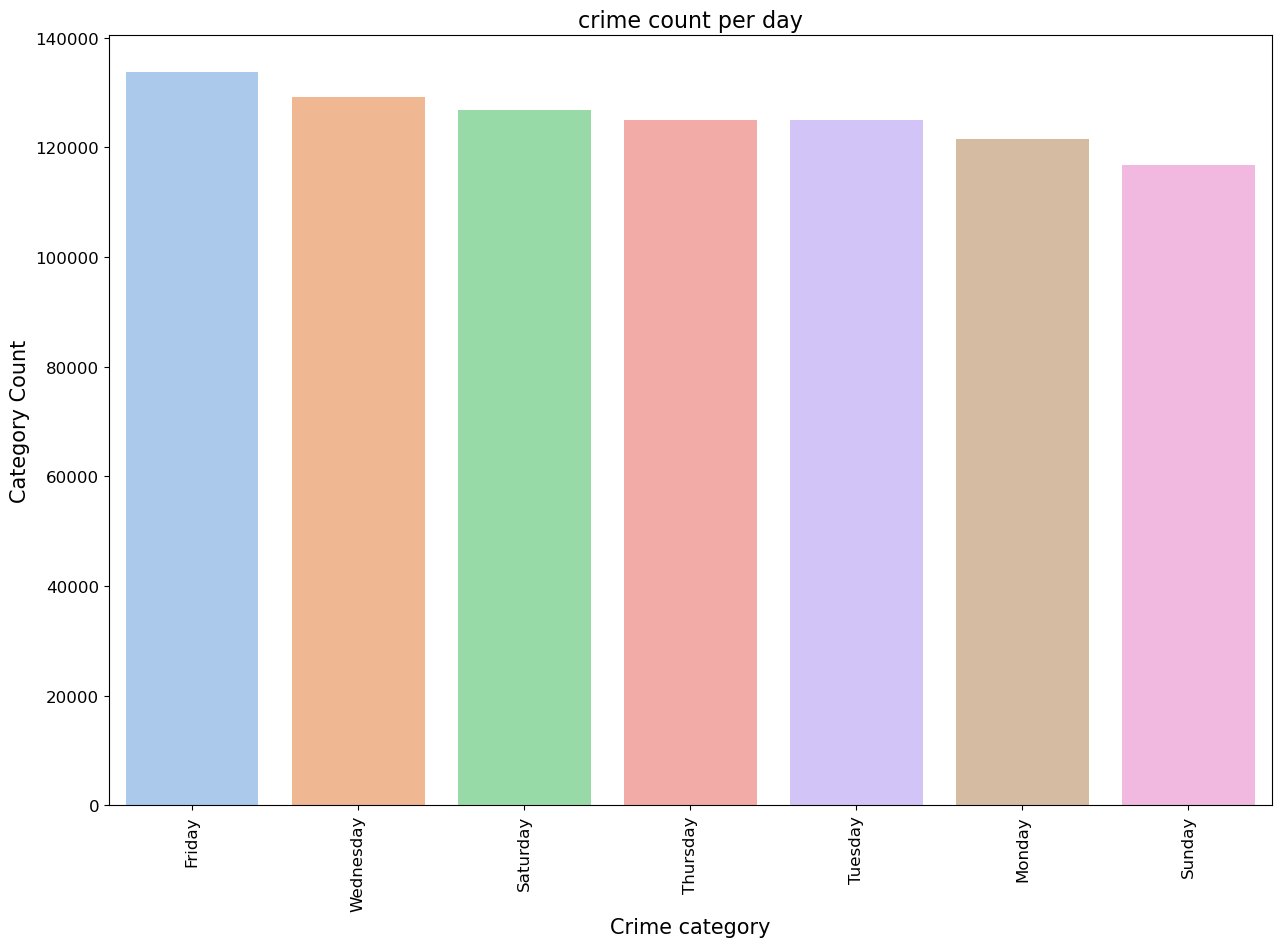

In [64]:
from pyspark.sql.functions import count, asc

day_count = df.groupBy("DayOfWeek").agg(count("Category").alias("crime_count_per_day"))\
.orderBy(desc("crime_count_per_day"))
day_count_list = day_count.limit(20).collect()
data_for_plot = [(row["DayOfWeek"], row["crime_count_per_day"]) for row in day_count_list]

# Extract data for plotting
x, y = zip(*data_for_plot)
#x = day_count.DayOfWeek
#y = day_count.crime_count_per_day
plt.clf()
plt.subplots(figsize=(15,10))
sns.barplot(x=list(x), y=list(y), palette= 'pastel')
#sns.hist(y)
plt.xlabel("Crime category", fontsize = 15)
plt.ylabel("Category Count", fontsize = 15)
plt.title("crime count per day", fontsize = 16)
plt.xticks(size = 12, rotation = 90)
plt.yticks(size = 12)
plt.show()
